In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import os

In [10]:
import sys
print(sys.executable)
!{sys.executable} -m pip show pytorch-tabnet


c:\Users\Electronica Care\Forecasting_Flights-DataScience\tf39-env\Scripts\python.exe


'c:\Users\Electronica' is not recognized as an internal or external command,
operable program or batch file.


In [5]:
# Path to your dataset
data_path = os.path.join('..', '..', 'data', 'processed', 'dl_ready_flights', 'dl_tabular_data.csv')

# Load dataset
df = pd.read_csv(data_path)

print("✅ Loaded data shape:", df.shape)
df.head()


✅ Loaded data shape: (600000, 53)


,FL_DATE,AIRLINE,AIRLINE_DOT,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,...,DAY_OF_WEEK_NORM,DEP_HOUR_NORM,MONTH_SIN,MONTH_COS,DAY_OF_WEEK_SIN,DAY_OF_WEEK_COS,DEP_HOUR_SIN,DEP_HOUR_COS,ORIGIN_FLIGHTS,ORIGIN_FLIGHTS_NORM
0,2021-07-25,0.944530,0.944530,1.067426,-1.552522,2.460211,-0.842944,-0.835750,-0.756873,-0.819571,...,1.513621,0.817800,-0.733237,-1.111240,-1.134983,0.871194,-1.181304,0.199712,1.468965,1.468965
1,2019-11-09,-1.266437,-1.266437,-1.397812,-0.453101,-1.314106,-1.059691,-1.101914,1.462173,1.218245,...,1.013834,-1.234219,-0.733237,1.341978,-1.411967,-0.308945,1.383718,0.199712,0.867214,0.867214
2,2023-05-26,0.944530,0.944530,1.067426,-1.552522,-0.453622,-1.049839,-0.940314,-1.585316,-1.495669,...,0.514047,-1.029017,0.688621,-1.111240,-0.635874,-1.255343,1.251075,-0.246307,-0.859627,-0.859627
3,2023-03-23,0.774456,0.774456,0.539160,0.878478,0.530202,-0.567084,-0.512550,0.840840,0.913525,...,0.014260,-1.439421,1.399550,0.115369,0.608882,-1.255343,1.428960,0.678350,-1.143316,-1.143316
4,2022-03-27,1.284679,1.284679,0.891337,0.005880,-1.048896,-0.606493,0.599636,1.264924,1.180155,...,1.513621,-0.208209,1.399550,0.115369,-1.134983,0.871194,0.101207,-1.170964,-0.024023,-0.024023


In [6]:
# Convert DEP_DELAY to numeric (force bad values to NaN)
df['DEP_DELAY'] = pd.to_numeric(df['DEP_DELAY'], errors='coerce')

# Show after fix
print(df['DEP_DELAY'].describe())
print("NaNs in DEP_DELAY after fix:", df['DEP_DELAY'].isna().sum())


count    600000.000000
mean          0.009300
std           1.091749
min          -0.294091
25%          -0.294091
50%          -0.294091
75%          -0.132652
max          53.989702
Name: DEP_DELAY, dtype: float64
NaNs in DEP_DELAY after fix: 0


In [7]:
# First convert to datetime temporarily
df['FL_DATE'] = pd.to_datetime(df['FL_DATE'], errors='coerce')

# Extract numeric date parts
df['FL_MONTH'] = df['FL_DATE'].dt.month
df['FL_DAY'] = df['FL_DATE'].dt.day
df['FL_DOW'] = df['FL_DATE'].dt.dayofweek

# Drop the original datetime column
df = df.drop(columns=['FL_DATE'])


In [8]:
# ✅ Remove 'CANCELLATION_CODE' column if it exists
if 'CANCELLATION_CODE' in df.columns:
    df = df.drop(columns=['CANCELLATION_CODE'])
    print("✅ 'CANCELLATION_CODE' column removed.")
else:
    print("ℹ️ 'CANCELLATION_CODE' column not found — nothing to remove.")


✅ 'CANCELLATION_CODE' column removed.


In [13]:
import numpy as np
import pandas as pd
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error

# === Load your data (replace with your CSV or DataFrame) ===
# df = pd.read_csv("your_flight_data.csv")
df = df.dropna()

target = 'DEP_DELAY'
X = df.drop(columns=[target])
y = df[target].values

# Encode categorical features if needed
for col in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

# Train-validation split
X_train, X_valid, y_train, y_valid = train_test_split(
    X.values, y, test_size=0.2, random_state=42
)

# Reshape targets for TabNet
y_train = y_train.reshape(-1, 1)
y_valid = y_valid.reshape(-1, 1)

# === Define custom evaluation metrics for TabNet ===
def rmse_metric(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def mse_metric(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

# TabNet expects metric names recognized by sklearn or its own, or callable
# It supports strings like 'mae' and custom functions that take y_true, y_pred.

# === Initialize TabNet regressor ===
model = TabNetRegressor()

# === Train the model ===
model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    eval_name=['valid'],
    eval_metric=['mae'],  # TabNet default metric (mean absolute error)
    max_epochs=100,
    patience=10,
    batch_size=1024,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
)

# === Predict on validation set ===
y_pred = model.predict(X_valid)

# === Calculate and print metrics ===
mae = mean_absolute_error(y_valid, y_pred)
mse = mean_squared_error(y_valid, y_pred)
rmse = np.sqrt(mse)

print(f"Validation MAE: {mae:.4f}")
print(f"Validation MSE: {mse:.4f}")
print(f"Validation RMSE: {rmse:.4f}")


c:\Users\Electronica Care\Forecasting_Flights-DataScience\tf39-env\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.03599 | valid_mae: 0.45982 |  0:00:05s
epoch 1  | loss: 0.95599 | valid_mae: 0.32293 |  0:00:11s
epoch 2  | loss: 0.74035 | valid_mae: 0.38108 |  0:00:16s
epoch 3  | loss: 0.7867  | valid_mae: 0.35907 |  0:00:21s
epoch 4  | loss: 0.60246 | valid_mae: 0.31295 |  0:00:27s
epoch 5  | loss: 0.46212 | valid_mae: 0.28243 |  0:00:32s
epoch 6  | loss: 0.34856 | valid_mae: 0.26988 |  0:00:37s
epoch 7  | loss: 0.27873 | valid_mae: 0.35151 |  0:00:43s
epoch 8  | loss: 0.2762  | valid_mae: 0.27943 |  0:00:48s
epoch 9  | loss: 0.23782 | valid_mae: 0.2361  |  0:00:53s
epoch 10 | loss: 0.23609 | valid_mae: 0.27263 |  0:00:59s
epoch 11 | loss: 0.24425 | valid_mae: 0.28258 |  0:01:04s
epoch 12 | loss: 0.2342  | valid_mae: 0.24094 |  0:01:09s
epoch 13 | loss: 0.22615 | valid_mae: 0.30598 |  0:01:15s
epoch 14 | loss: 0.20563 | valid_mae: 0.24065 |  0:01:20s
epoch 15 | loss: 0.2584  | valid_mae: 0.23314 |  0:01:25s
epoch 16 | loss: 0.2076  | valid_mae: 0.26814 |  0:01:31s
epoch 17 | los

c:\Users\Electronica Care\Forecasting_Flights-DataScience\tf39-env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Validation MAE: 0.2237
Validation MSE: 0.1258
Validation RMSE: 0.3547


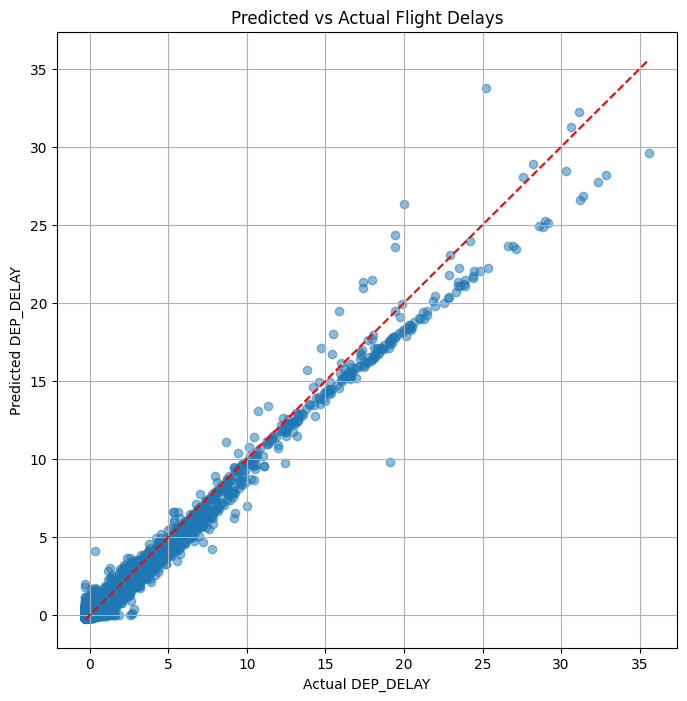

In [15]:
plt.figure(figsize=(8, 8))
plt.scatter(y_valid, y_pred, alpha=0.5)
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'r--')  # Diagonal line
plt.xlabel('Actual DEP_DELAY')
plt.ylabel('Predicted DEP_DELAY')
plt.title('Predicted vs Actual Flight Delays')
plt.grid(True)
plt.show()


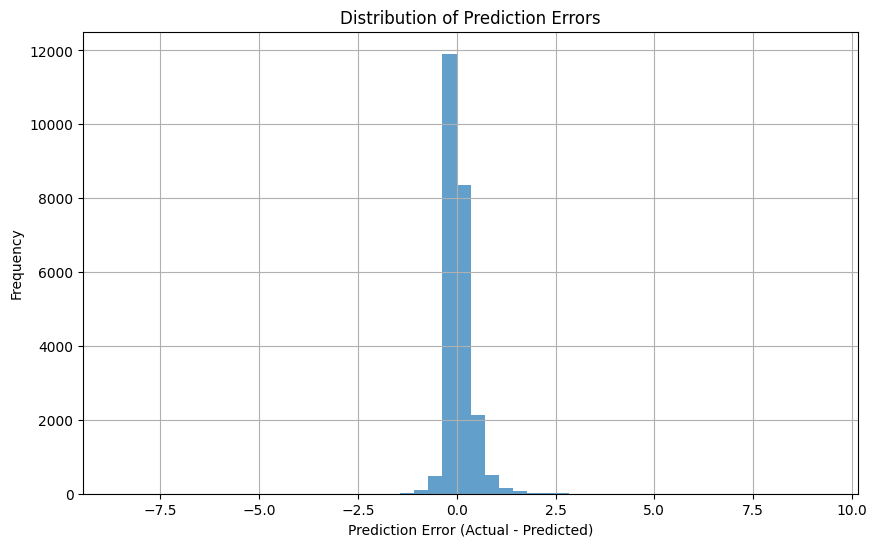

In [16]:
residuals = y_valid.flatten() - y_pred.flatten()

plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, alpha=0.7)
plt.xlabel('Prediction Error (Actual - Predicted)')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.grid(True)
plt.show()
